# Sign Language Classifier
Using the Sign Language MNIST from Kaggle (https://www.kaggle.com/datamunge/sign-language-mnist/home)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import subprocess
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load data

In [2]:
## Unzip
zip_ref = zipfile.ZipFile('data/sign-language-mnist.zip','r')
zip_ref.extractall('data/sign-language')
zip_ref.close()

In [3]:
def get_data(filename):
    df = pd.read_csv(filename)
    images = df.drop('label', axis=1).values
    images = np.array([np.array_split(i, 28) for i in images])
    labels = df.label
    print(images.shape, labels.shape)
    
    return images, labels

In [4]:
training_images, training_labels = get_data('data/sign-language/sign_mnist_train.csv')
testing_images, testing_labels = get_data('data/sign-language/sign_mnist_test.csv')

(27455, 28, 28) (27455,)
(7172, 28, 28) (7172,)


#### Here are the true labels

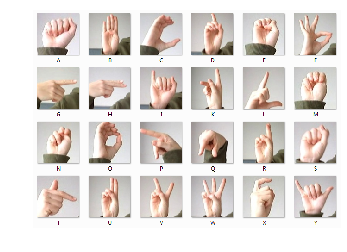

In [5]:
## cheatsheet
img = mpimg.imread('data/sign-language/amer_sign2.png')
plt.imshow(img)
plt.axis('off')
plt.show()

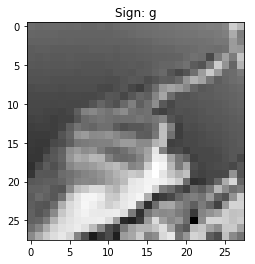

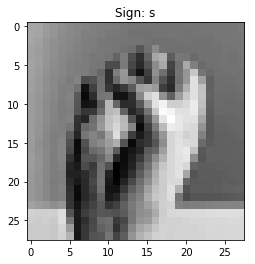

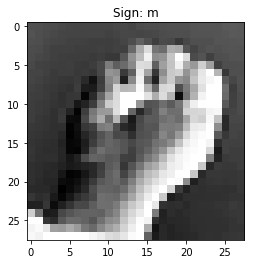

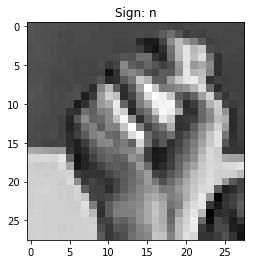

In [6]:
## Index to character
def pos_to_char(pos):
    return chr(pos + 97)

img = training_images[1,:]
plt.imshow(img, cmap='Greys')
plt.title('Sign: %s' % pos_to_char(training_labels[1]))
plt.show()

img = training_images[10,:]
plt.title('Sign: %s' % pos_to_char(training_labels[10]))
plt.imshow(img, cmap='Greys')
plt.show()

img = training_images[100,:]
plt.title('Sign: %s' % pos_to_char(training_labels[100]))
plt.imshow(img, cmap='Greys')
plt.show()

img = training_images[1000,:]
plt.title('Sign: %s' % pos_to_char(training_labels[1000]))
plt.imshow(img, cmap='Greys')
plt.show()

In [7]:
training_images =  np.expand_dims(training_images, axis=3)
testing_images =  np.expand_dims(testing_images, axis=3)

print(training_images.shape, testing_images.shape)

(27455, 28, 28, 1) (7172, 28, 28, 1)


## Model training

In [8]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(26, activation=tf.nn.softmax)
])

model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )

history = model.fit_generator(training_datagen.flow(training_images, training_labels, batch_size=32),
                              steps_per_epoch=len(training_images)/32,
                              epochs=50,
                              validation_data = validation_datagen.flow(testing_images, testing_labels,batch_size=32),
                              validation_steps = len(testing_images)/32
                             )

W0824 20:55:28.563790 140152287577920 deprecation.py:506] From /home/elder/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/50
858/857 [==============================] - 14s 16ms/step - loss: 2.7833 - acc: 0.1569 - val_loss: 1.9969 - val_acc: 0.3660
Epoch 2/50
858/857 [==============================] - 14s 16ms/step - loss: 2.0588 - acc: 0.3472 - val_loss: 1.3121 - val_acc: 0.5825
Epoch 3/50
858/857 [==============================] - 14s 16ms/step - loss: 1.6689 - acc: 0.4645 - val_loss: 1.0734 - val_acc: 0.6429
Epoch 4/50
858/857 [==============================] - 14s 16ms/step - loss: 1.4335 - acc: 0.5337 - val_loss: 1.0523 - val_acc: 0.6386
Epoch 5/50
858/857 [==============================] - 14s 16ms/step - loss: 1.2718 - acc: 0.5860 - val_loss: 0.8056 - val_acc: 0.7137
Epoch 6/50
858/857 [==============================] - 14s 16ms/step - loss: 1.1523 - acc: 0.6233 - val_loss: 0.7183 - val_acc: 0.7658
Epoch 7/50
858/857 [==============================] - 14s 16ms/step - loss: 1.0506 - acc: 0.6603 - val_loss: 0.5650 - val_acc: 0.8047
Epoch 8/50
858/857 [==============================] - 14s 17ms

In [10]:
model.evaluate(testing_images/255., testing_labels)

7172/7172 [==============================] - 1s 151us/sample - loss: 0.1604 - acc: 0.9441


[0.1604242261784978, 0.9440881]

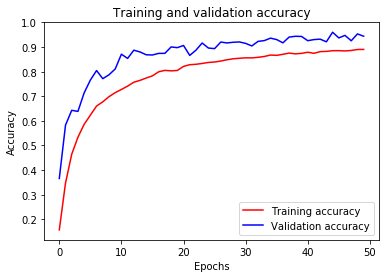

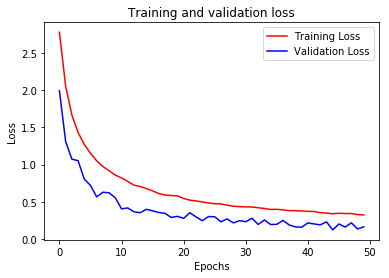

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Visualize predictions

In [12]:
predicted_labels = model.predict(testing_images/255.)
print(predicted_labels)

[[1.5801226e-09 5.8695262e-12 1.2238654e-05 ... 2.0919887e-03
  1.5187922e-09 6.9080400e-24]
 [5.2521056e-12 5.6001204e-07 5.8928377e-23 ... 2.0542573e-19
  8.8275438e-03 7.3266078e-35]
 [5.6303556e-16 7.9425502e-18 1.0895958e-11 ... 5.8366757e-14
  1.3009929e-10 6.1783362e-31]
 ...
 [5.9590559e-18 5.5210793e-16 9.9998617e-01 ... 4.8078807e-12
  3.7681284e-21 0.0000000e+00]
 [2.7791415e-07 2.9452638e-10 5.1547133e-18 ... 2.1331987e-16
  2.3868585e-10 1.6158412e-38]
 [8.5698535e-20 1.1180961e-17 9.9999881e-01 ... 3.1699713e-13
  1.1552053e-23 0.0000000e+00]]


In [13]:
def plot_prediction(index):
    img = testing_images[index,:,:,0]
    true_label = pos_to_char(testing_labels[index])
    predicted_label = pos_to_char(np.argmax(predicted_labels[index]))
    plt.title('Sign: %s. Predicted: %s' % (true_label, predicted_label))
    plt.imshow(img, cmap='Greys')
    plt.show()

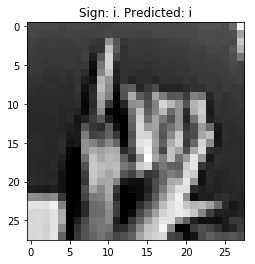

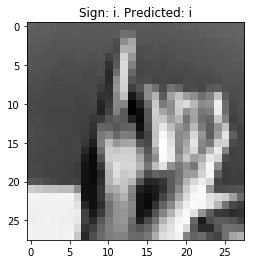

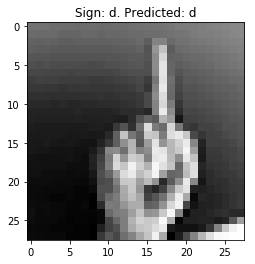

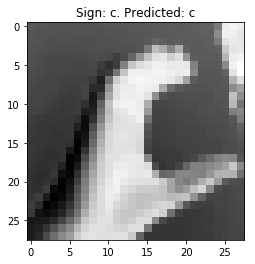

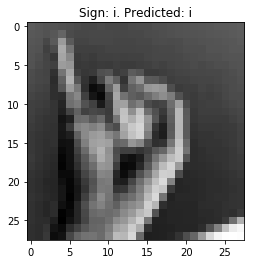

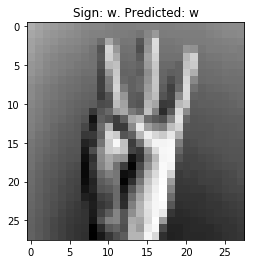

In [14]:
plot_prediction(10)
plot_prediction(100)
plot_prediction(1000)
plot_prediction(2000)
plot_prediction(3000)
plot_prediction(4000)

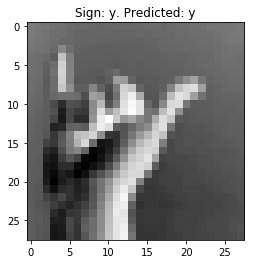

In [15]:
plot_prediction(5000)